Motion Phantom Simulation and Reconstruction Demo

Author:

  * Zhengguo Tan <zhengguo.tan@gmail.com>

# 1. Setup

## Connect to a GPU on `Google Colab`

  * Go to `Edit` > `Notebook settings` > select `GPU` > click `Save`;
  * Now we can verify that we allocate a GPU for this notebook.

In [1]:
!nvidia-smi
!nvcc --version

Sat Aug  5 10:09:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install SigPy

  * The original [SigPy](https://github.com/mikgroup/sigpy.git) was fored for the development of HD-MRI reconstruction and is available here: https://github.com/ZhengguoTan/sigpy.git

In [2]:
!git clone https://github.com/ZhengguoTan/sigpy.git

Cloning into 'sigpy'...
remote: Enumerating objects: 6394, done.
remote: Counting objects: 100% (930/930), done.
remote: Compressing objects: 100% (349/349), done.
remote: Total 6394 (delta 632), reused 811 (delta 567), pack-reused 5464
Receiving objects: 100% (6394/6394), 3.83 MiB | 25.46 MiB/s, done.
Resolving deltas: 100% (4652/4652), done.


In [3]:
%cd /content/sigpy
!git log -1

/content/sigpy
commit 177bf582897e0a0251414ab933098577d0ce6616 (HEAD -> master, origin/master, origin/HEAD)
Author: Zhengguo Tan <zhengguo.tan@gmail.com>
Date:   Tue Aug 1 14:33:46 2023 +0200

    simulate a dynamic shepp logan phantom


In [4]:
!pip install -e /content/sigpy

Obtaining file:///content/sigpy
  Preparing metadata (setup.py) ... done
  Running setup.py develop for sigpy


# 2. Simulation

### Motion phantom

In [5]:
%%bash
cd /content/
pwd

cd /content/sigpy

/content


In [6]:
%matplotlib inline
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
import sigpy as sp

import sigpy.mri.sim as mrisim
from sigpy.mri import app
from sigpy import linop
from IPython.display import Image

In [7]:
import torch

device = sp.Device(0 if torch.cuda.is_available() else -1)
print(device)

<CUDA Device 0>


In [8]:
N_frame, N_z, N_y, N_x = 18, 1, 320, 320

orig_img = sp.sim.dynamic_shepp_logan([N_frame, N_z, N_y, N_x])

print(orig_img.shape)

(18, 1, 320, 320)


In [35]:
def save_gif(input, gif_name='phantom.gif'):

    frames = []

    Nt, Ny, Nx = np.squeeze(input).shape

    for t in range(input.shape[0]):
        fig, ax = plt.subplots()

        ax.imshow(abs(np.squeeze(input[t, ...])), cmap='gray')
        ax.text(int(0.02 * Nx), int(0.05 * Ny), 'Frame ' + str(t).zfill(3),
                color='w')
        ax.set_aspect('equal')
        ax.set_axis_off()

        fig_name = f'{t}.png'
        plt.savefig(fig_name)
        plt.close()

        frames.append(imageio.imread(fig_name))

    # Save the frames as a GIF
    output_file = gif_name
    # Adjust the duration between frames as needed
    imageio.mimsave(output_file, frames, duration=1)

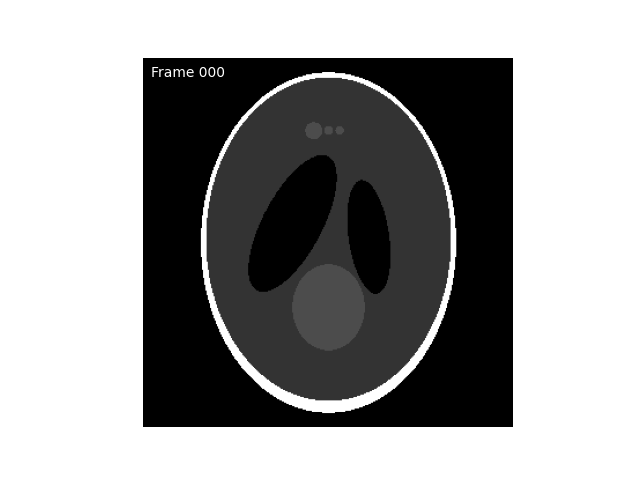

In [36]:
save_gif(orig_img, 'motion_phantom.gif')

# display gif
Image(open('motion_phantom.gif', 'rb').read())

### Coils

(3, 320, 320)


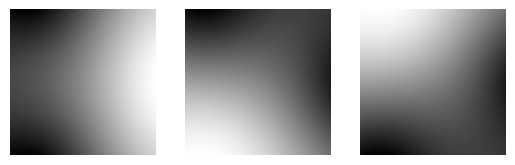

In [11]:
N_coil = 3
orig_mps = mrisim.birdcage_maps([N_coil, N_y, N_x])

print(orig_mps.shape)

fig, ax = plt.subplots(1, 3)

for c in range(N_coil):
    ax[c].imshow(abs(np.squeeze(orig_mps[c])), cmap='gray')
    ax[c].set_axis_off()

plt.show()

In [12]:
orig_ksp = sp.fft(orig_img * orig_mps, axes=(-2, -1))

orig_ksp = orig_ksp + np.random.normal(loc=0,
                                       scale=0.005,
                                       size=orig_ksp.shape)

print(orig_ksp.shape)

(18, 3, 320, 320)


### Trajectory

In [13]:
def get_trj(N_frame, N_ro, N_spoke):

    tau = (1 + np.sqrt(5)) / 2
    ga = np.deg2rad(180 / (2 + tau - 1))

    kx = np.zeros(shape=(N_ro, N_spoke * N_frame))
    ky = np.zeros(shape=(N_ro, N_spoke * N_frame))

    ln = (np.arange(N_ro) - N_ro//2) # line

    for n in range(kx.shape[-1]):
        # print('%4d, %12.6f'%(n, n*ga))
        kx[:, n] = np.cos(n * ga) * ln
        ky[:, n] = np.sin(n * ga) * ln

    trj = np.stack((kx, ky))
    trj = np.reshape(trj, list(trj.shape[:-1]) + [N_frame, N_spoke])
    trj = np.transpose(trj, (2, 0, 1, 3))

    return trj

In [14]:
N_ro = N_x * 2
grid_size = (N_ro, N_ro)

N_spoke_fsamp = int(N_x * np.pi / 2)
print('fully-sampled spokes number: ', N_spoke_fsamp)

N_spoke_usamp = 21
print('under-sampled spokes number: ', N_spoke_usamp)

trj_usamp = get_trj(N_frame, N_ro, N_spoke_usamp)
trj_usamp_sp = np.transpose(trj_usamp, (0, 3, 2, 1))

print(trj_usamp_sp.shape)

fully-sampled spokes number:  502
under-sampled spokes number:  21
(18, 21, 640, 2)


### Radial k-space data

(18, 3, 21, 640)


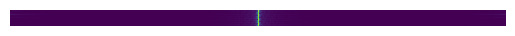

22.813758518335447
3.076185310688616e-05


In [15]:
radialx_ksp = np.zeros([N_frame, N_coil, N_spoke_usamp, N_ro], dtype=complex)

for n in range(0, N_frame):
    traj_r = trj_usamp_sp[n, ...]
    temp_i = sp.ifft(orig_ksp, axes=(-2, -1))[n, ...]
    F = linop.NUFFT(orig_mps.shape, traj_r)
    radialx_ksp[n, ...] = F * temp_i

print(radialx_ksp.shape)

fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
plt.imshow(np.abs(radialx_ksp[10, 0, ...]))
plt.axis('off')
plt.show()

print(np.max(np.abs(radialx_ksp)))
print(np.min(np.abs(radialx_ksp)))

# 3. Reconstruction

### SENSE

In [16]:
radialx_pi = []
for n in range(0, N_frame):
    ksp1 = radialx_ksp[n, ...]
    trj1 = trj_usamp_sp[n, ...]
    R = app.SenseRecon(ksp1, orig_mps,
                        coord=trj1,
                        lamda=0.01, max_iter=20,
                        device=device).run()

    radialx_pi.append(sp.to_device(R))

radialx_pi = np.array(radialx_pi)

print(radialx_pi.shape)

SenseRecon:   0%|          | 0/20 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/20 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/20 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/20 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/20 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/20 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/20 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/20 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/20 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/20 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/20 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/20 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/20 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/20 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/20 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/20 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/20 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/20 [00:00<?, ?it/s]

(18, 320, 320)


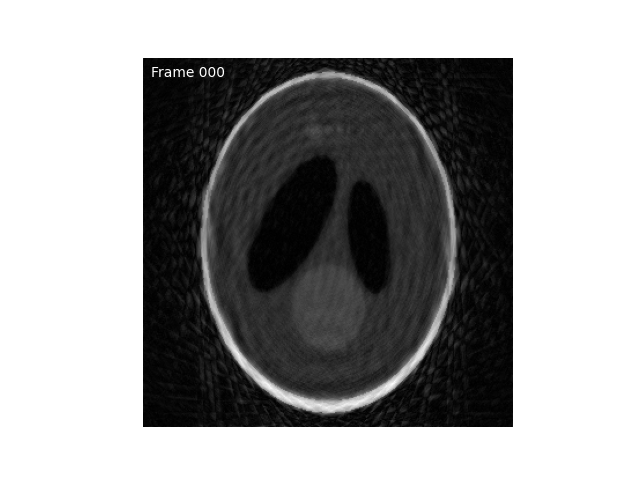

In [37]:
save_gif(radialx_pi, 'motion_phantom_pi.gif')

# display gif
Image(open('motion_phantom_pi.gif', 'rb').read())

### SENSE with temporal regularization

In [38]:
print(radialx_ksp.shape)
print(trj_usamp_sp.shape)

ishape = (N_x, N_x)

S = linop.Multiply(ishape, orig_mps)

x_curr = np.zeros_like(radialx_ksp, shape=ishape)

radialx_tpi = []
for n in range(0, N_frame):

    print('> frame ', str(n).zfill(3))

    ksp1 = radialx_ksp[n, ...]
    trj1 = trj_usamp_sp[n, ...]

    F = linop.NUFFT(S.oshape, trj1)
    A = F * S

    lamda = 0.01
    x_prev = 0.9 * x_curr.copy()

    AHy = A.H(ksp1) + lamda * x_prev

    alg_method = sp.alg.ConjugateGradient(
        lambda x : A.N(x) + lamda * x,
        AHy, x_curr, max_iter=20,
        verbose=True
    )

    while (not alg_method.done()):
        alg_method.update()

    radialx_tpi.append(x_curr.copy())

radialx_tpi = np.array(radialx_tpi)

print(radialx_tpi.shape)

(18, 3, 21, 640)
(18, 21, 640, 2)
> frame  000
  cg iter:  0; resid:    115.496429
  cg iter:  1; resid:     57.926403
  cg iter:  2; resid:     37.693533
  cg iter:  3; resid:     24.817380
  cg iter:  4; resid:     15.313112
  cg iter:  5; resid:      9.573724
  cg iter:  6; resid:      5.256785
  cg iter:  7; resid:      4.362464
  cg iter:  8; resid:      3.207539
  cg iter:  9; resid:      3.129751
  cg iter: 10; resid:      2.075151
  cg iter: 11; resid:      1.624180
  cg iter: 12; resid:      1.417803
  cg iter: 13; resid:      1.031112
  cg iter: 14; resid:      0.887417
  cg iter: 15; resid:      0.791008
  cg iter: 16; resid:      1.425794
  cg iter: 17; resid:      0.797114
  cg iter: 18; resid:      0.555569
  cg iter: 19; resid:      0.555569
> frame  001
  cg iter:  0; resid:     23.439756
  cg iter:  1; resid:     17.240973
  cg iter:  2; resid:      8.142373
  cg iter:  3; resid:      4.893720
  cg iter:  4; resid:      3.235595
  cg iter:  5; resid:      2.224254
  cg

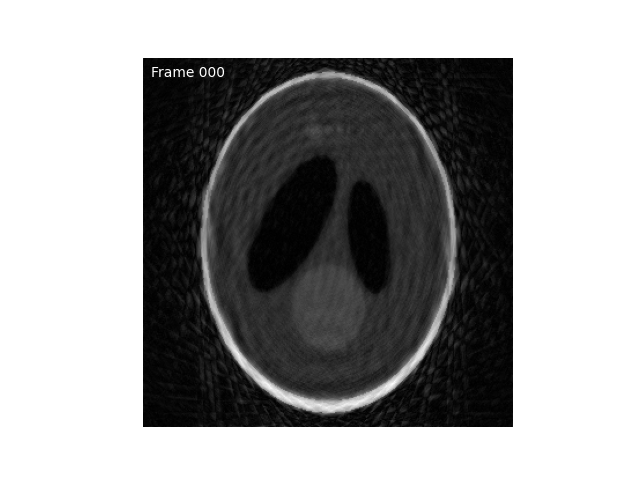

In [39]:
save_gif(radialx_tpi, 'motion_phantom_tpi.gif')

# display gif
Image(open('motion_phantom_tpi.gif', 'rb').read())

### Joint reconstruction with temporal total variation regularization

In [40]:
radialx_ksp6 = radialx_ksp[:, None, :, None, :, :]
orig_mps4 = orig_mps[:, None, :, :]

radialx_tv = app.HighDimensionalRecon(radialx_ksp6, orig_mps4,
                        combine_echo=False,
                        lamda=0.001,
                        coord=trj_usamp_sp,
                        regu='TV', regu_axes=[0],
                        max_iter=10,
                        solver='ADMM', rho=0.1,
                        device=device,
                        show_pbar=False,
                        verbose=False).run()

radialx_tv = sp.to_device(radialx_tv)
print(radialx_tv.shape)

(18, 1, 1, 1, 320, 320)


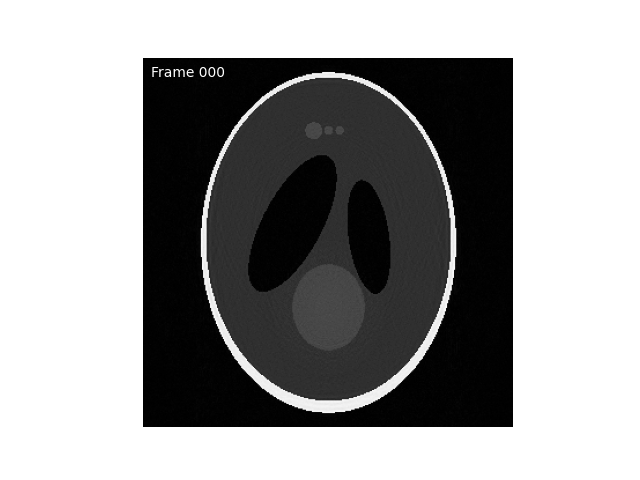

In [41]:
save_gif(np.squeeze(radialx_tv), 'motion_phantom_tv.gif')

# display gif
Image(open('motion_phantom_tv.gif', 'rb').read())